## Imports

In [1]:
!pip install transformers torch torchvision Pillow
!pip install open_clip_torch
!pip install tqdm psutil scikit-learn matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import os
import time
import json
from pathlib import Path

import pandas as pd
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
from tqdm import tqdm
import psutil
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import open_clip

In [ ]:
# à modifier selon votre chemin

base_path = "Ressources/"

csv_physique = base_path + "inventaire_physique.csv"
csv_comptable = base_path + "inventaire_comptable.csv"
img_folder = base_path + "Images/"

## Préparation des données

1/ Inventaire physique réduit => columns : Img/Titre/codeEtiquette/NumInventaire

2/ Inventaire comptable => NumInventaire/des1/fournisseur

3/ lien entre les 2 (numInventaire) => correspondances réelles

In [ ]:
df_physique = pd.read_csv(csv_physique)
df_comptable = pd.read_csv(csv_comptable,sep=";",encoding="latin-1")

C:\Users\louis\AppData\Local\Temp\ipykernel_11940\3699852166.py:1: DtypeWarning: Columns (1,9,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_physique = pd.read_csv(csv_physique)


In [ ]:
# Harmonisation du NumInventaire
df_physique = df_physique.rename(columns={"Num Inventaire": "NumInventaire"})
df_comptable = df_comptable.rename(columns={"numInventaire": "NumInventaire"})

# Supprime les lignes sans identifiant
df_physique = df_physique.dropna(subset=["NumInventaire"])
df_comptable = df_comptable.dropna(subset=["NumInventaire"])

In [ ]:
# Création df commun
df_merged = pd.merge(
    df_physique,
    df_comptable,
    on="NumInventaire",
    how="inner"
)

print(len(df_merged), "correspondances trouvées dans le dataset")

6894 correspondances trouvées dans le dataset


In [ ]:
# Création d’un texte descriptif pour chaque fiche comptable
df_merged["fiche_textuelle"] = (
    df_merged["des1"].fillna('') +
    ' ' + df_merged["des2"].fillna('') + ' '
    + df_merged["fournisseur"].fillna('')
).str.strip()

# Sélection des colonnes importantes
df_final = df_merged[[
    "Titre",
    "Img",
    "NumInventaire",
    "fiche_textuelle"
]]

df_final.head()

,Titre,Img,NumInventaire,fiche_textuelle
0,Chaise,b7c180e6-13d0-4365-afe7-c83a25746d8d.jpg,202000166,CHAISE APPUI SUR TABLE LOLA REF. 2748678 UGAP
1,Chaise,c88762c5-3c03-4ad2-8a8a-b02add20dc4d.jpg,202000166,CHAISE APPUI SUR TABLE LOLA REF. 2748678 UGAP
2,Chaise,63474d32-c1a6-44c1-b3f5-62bdcc2f8d24.jpg,9616256,CHAISE EMPILABLE 250 ASSISE ET DOSSIER BOIS CO...
3,Chaise,2ab1675c-8c43-4490-9c9d-23e86b1d3a50.jpg,9616256,CHAISE EMPILABLE 250 ASSISE ET DOSSIER BOIS CO...
4,Chaise pliante,6eb45daf-4706-49b9-af22-82b384e06fbc.jpg,202100185,CHAISE PLIANTE - LOT DE 4 REF. 2197403 - COULE...


In [ ]:
df_test_sample = df_final.sample(n=50 , random_state=42).reset_index(drop=True)

## Initialisation du modèle

In [ ]:
import torch
import open_clip

device = "cuda" if torch.cuda.is_available() else "cpu"

model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai')
tokenizer = open_clip.get_tokenizer('ViT-B-32')
model = model.to(device)
model.eval()

c:\Users\louis\OneDrive\Documents\00 - Cours\FIE5\PTUT_CEVEOP\envCeveop\Lib\site-packages\open_clip\factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine

## Génération des embeddings

In [ ]:
df_test_sample["Img_path"] = df_test_sample["Img"].apply(lambda x: img_folder + x)

In [ ]:
def load_image(path):
    try:
        return Image.open(path).convert("RGB")
    except:
        print(f"⚠️ Impossible de charger {path}")
        return None

df_test_sample["image_obj"] = df_test_sample["Img_path"].apply(load_image)

In [ ]:
image_embeds = []
text_embeds = []

for _, row in tqdm(df_final.iterrows(), total=len(df_final)):
    try:
        img = Image.open(img_folder + row["Img"]).convert("RGB")
        image_tensor = preprocess(img).unsqueeze(0).to(device)
        text_tokens = tokenizer([row["fiche_textuelle"]]).to(device)

        with torch.no_grad():
            img_emb = model.encode_image(image_tensor)
            txt_emb = model.encode_text(text_tokens)

        image_embeds.append(img_emb.cpu())
        text_embeds.append(txt_emb.cpu())

    except:
        continue

image_embeds = torch.cat(image_embeds)
text_embeds = torch.cat(text_embeds)

# Normalisation
image_embeds = image_embeds / image_embeds.norm(dim=1, keepdim=True)
text_embeds = text_embeds / text_embeds.norm(dim=1, keepdim=True)

100%|██████████| 6894/6894 [29:15<00:00,  3.93it/s]


In [ ]:
import torch.nn as nn
import torch.optim as optim

# Découper train/test (80/20)
n = len(image_embeds)
idx = torch.randperm(n)
split = int(0.8 * n)
train_idx, test_idx = idx[:split], idx[split:]

train_img, train_txt = image_embeds[train_idx], text_embeds[train_idx]
test_img, test_txt = image_embeds[test_idx], text_embeds[test_idx]
embed_dim = image_embeds.shape[1]

class ProjectionHead(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.proj_img = nn.Linear(dim, dim)
        self.proj_txt = nn.Linear(dim, dim)

    def forward(self, img_emb, txt_emb):
        img_proj = self.proj_img(img_emb)
        txt_proj = self.proj_txt(txt_emb)
        # Normalisation pour la similarité cosinus
        img_proj = img_proj / img_proj.norm(dim=1, keepdim=True)
        txt_proj = txt_proj / txt_proj.norm(dim=1, keepdim=True)
        return img_proj, txt_proj

proj_head = ProjectionHead(embed_dim).to(device)


Epoch 1/10 | Loss=0.0019 | Top1=0.067 | Top5=0.207 | MRR=0.139
Epoch 2/10 | Loss=0.0011 | Top1=0.073 | Top5=0.239 | MRR=0.156
Epoch 3/10 | Loss=0.0008 | Top1=0.096 | Top5=0.269 | MRR=0.181
Epoch 4/10 | Loss=0.0006 | Top1=0.102 | Top5=0.289 | MRR=0.191
Epoch 5/10 | Loss=0.0005 | Top1=0.102 | Top5=0.305 | MRR=0.196
Epoch 6/10 | Loss=0.0004 | Top1=0.104 | Top5=0.306 | MRR=0.201
Epoch 7/10 | Loss=0.0003 | Top1=0.114 | Top5=0.321 | MRR=0.209
Epoch 8/10 | Loss=0.0003 | Top1=0.113 | Top5=0.333 | MRR=0.215
Epoch 9/10 | Loss=0.0002 | Top1=0.130 | Top5=0.342 | MRR=0.229
Epoch 10/10 | Loss=0.0002 | Top1=0.124 | Top5=0.345 | MRR=0.227


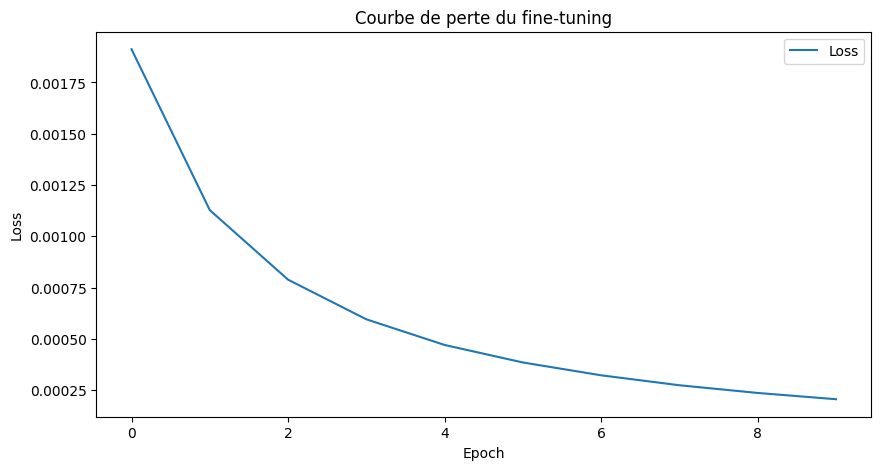

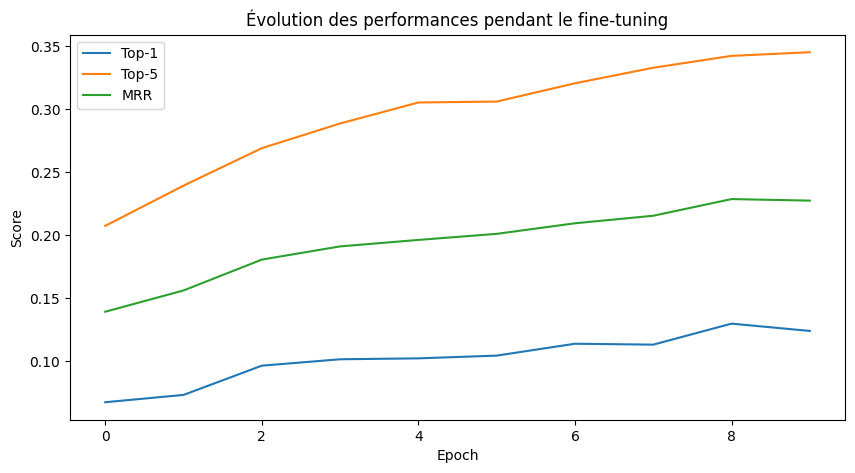

✅ Fine-tuning terminé ! Modèle sauvegardé sous 'projection_head_openclip.pt'


In [ ]:
optimizer = optim.Adam(proj_head.parameters(), lr=1e-4)
criterion = nn.CosineEmbeddingLoss()

# ========================================================
# 4️⃣ Boucle d'entraînement + validation
# ========================================================
EPOCHS = 15
BATCH_SIZE = 32
losses, top1_scores, top5_scores, mrr_scores = [], [], [], []

for epoch in range(EPOCHS):
    proj_head.train()
    total_loss = 0
    perm = torch.randperm(len(train_img))
    for i in range(0, len(train_img), BATCH_SIZE):
        idx = perm[i:i+BATCH_SIZE]
        img_batch = train_img[idx].to(device)
        txt_batch = train_txt[idx].to(device)
        target = torch.ones(img_batch.size(0)).to(device)

        img_proj, txt_proj = proj_head(img_batch, txt_batch)
        loss = criterion(img_proj, txt_proj, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / (len(train_img) // BATCH_SIZE)
    losses.append(avg_loss)
    proj_head.eval()
    with torch.no_grad():
        img_proj, txt_proj = proj_head(test_img.to(device), test_txt.to(device))
        sim_matrix = img_proj @ txt_proj.T

    sim_matrix = sim_matrix.cpu()
    num_samples = sim_matrix.shape[0]
    indices_correct = []

    for i in range(num_samples):
        sims = sim_matrix[i]
        ranking = torch.argsort(sims, descending=True)
        indices_correct.append(ranking.tolist().index(i))

    indices_correct = np.array(indices_correct)
    top1 = np.mean(indices_correct == 0)
    top5 = np.mean(indices_correct < 5)
    mrr = np.mean(1 / (indices_correct + 1))

    top1_scores.append(top1)
    top5_scores.append(top5)
    mrr_scores.append(mrr)

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss={avg_loss:.4f} | Top1={top1:.3f} | Top5={top5:.3f} | MRR={mrr:.3f}")

# ========================================================
# 5️⃣ Sauvegarde et graphiques
# ========================================================
torch.save(proj_head.state_dict(), "projection_head_openclip.pt")

plt.figure(figsize=(10,5))
plt.plot(losses, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de perte du fine-tuning")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(top1_scores, label="Top-1")
plt.plot(top5_scores, label="Top-5")
plt.plot(mrr_scores, label="MRR")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Évolution des performances pendant le fine-tuning")
plt.legend()
plt.show()

print("✅ Fine-tuning terminé ! Modèle sauvegardé sous 'projection_head_openclip.pt'")

## Evaluation du modèle

In [ ]:
import torch.nn.functional as F

image_embeddings = F.normalize(image_embeddings, dim=1)
text_embeddings = F.normalize(text_embeddings, dim=1)

similarity_matrix = image_embeddings @ text_embeddings.T


In [ ]:
import numpy as np

num_samples = len(df_test_sample)
indices_correct = []

for i in range(num_samples):
    sims = similarity_matrix[i]
    ranking = torch.argsort(sims, descending=True)
    true_index = i  # correspondance via NumInventaire ou position
    indices_correct.append(ranking.tolist().index(true_index))

indices_correct = np.array(indices_correct)

top1 = np.mean(indices_correct == 0)
top5 = np.mean(indices_correct < 5)
mrr = np.mean(1 / (indices_correct + 1))


In [ ]:
def precision_recall_f1_at_k(k):
    hits = (indices_correct < k).sum()
    precision = hits / (k * num_samples)
    recall = hits / num_samples
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    return precision, recall, f1

for k in [1, 5, 10]:
    p, r, f1 = precision_recall_f1_at_k(k)
    print(f"k={k} → Precision={p:.3f} | Recall={r:.3f} | F1={f1:.3f}")


k=1 → Precision=0.120 | Recall=0.120 | F1=0.120
k=5 → Precision=0.064 | Recall=0.320 | F1=0.107
k=10 → Precision=0.052 | Recall=0.520 | F1=0.095


In [ ]:
import torch
import numpy as np

# similarity_matrix : (n_images x n_textes), déjà calculée
num_samples = similarity_matrix.shape[0]

# indices du vrai texte pour chaque image
# Si tes images et textes sont dans le même ordre, c'est juste la diagonale
true_indices = np.arange(num_samples)

top1_count = 0
top5_count = 0
top50_count = 0

for i in range(num_samples):
    sims = similarity_matrix[i]
    ranking = torch.argsort(sims, descending=True)  # indices triés du plus proche au plus éloigné
    true_idx = true_indices[i]

    if ranking[0].item() == true_idx:
        top1_count += 1
    if true_idx in ranking[:5].tolist():
        top5_count += 1
    if true_idx in ranking[:50].tolist():
        top50_count += 1

top1_accuracy = top1_count / num_samples
top5_accuracy = top5_count / num_samples
top50_accuracy = top50_count / num_samples

print(f"Top-1 Accuracy : {top1_accuracy:.3f}")
print(f"Top-5 Accuracy : {top5_accuracy:.3f}")
print(f"Top-50 Accuracy : {top50_accuracy:.3f}")

Top-1 Accuracy : 0.120
Top-5 Accuracy : 0.320
Top-50 Accuracy : 1.000


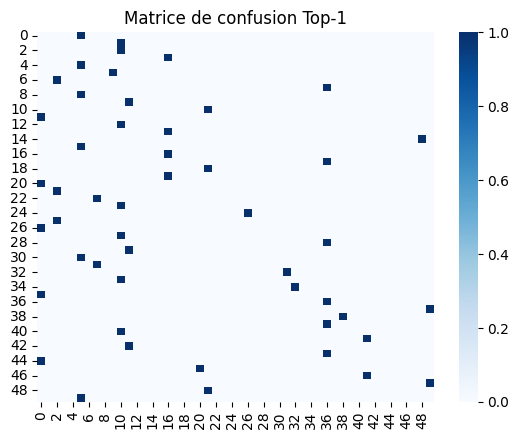

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = list(range(num_samples))
y_pred = [torch.argsort(similarity_matrix[i], descending=True)[0].item() for i in range(num_samples)]

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, cmap="Blues")
plt.title("Matrice de confusion Top-1")
plt.show()


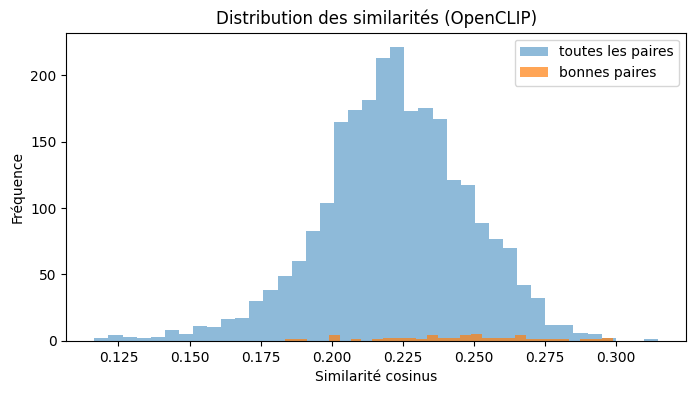

In [ ]:
correct_sims = [similarity_matrix[i, i].item() for i in range(num_samples)]
all_sims = similarity_matrix.flatten().numpy()

plt.figure(figsize=(8,4))
plt.hist(all_sims, bins=40, alpha=0.5, label="toutes les paires")
plt.hist(correct_sims, bins=30, alpha=0.7, label="bonnes paires")
plt.legend()
plt.title("Distribution des similarités (OpenCLIP)")
plt.xlabel("Similarité cosinus")
plt.ylabel("Fréquence")
plt.show()


## Test

🎲 Exemples aléatoires :



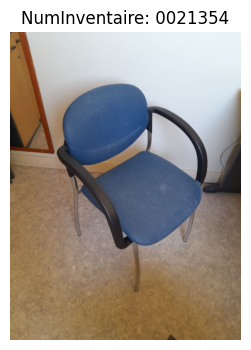

→ Fiche textuelle prédite :
 FAUTEUIL CLUB DREAM - NOIR REF. 1468958 UGAP
→ Fiche textuelle correcte :
 FAUTEUILS SUMO AVEC ACCOTOIRS REF SO/4P + A28 + CH COLORIS RA20 (6)COLORIS DIRECT EQUIPEMENT SARL
--------------------------------------------------------------------------------


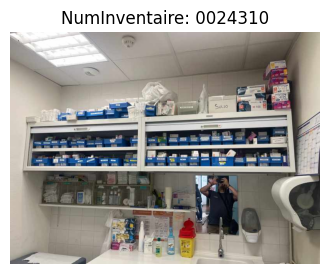

→ Fiche textuelle prédite :
 1 ARMOIRE A PHARMACIE MURALE REFERENCE 30857 - (CMP de Dourdan ETABLISSEMENTS VILLARD SA
→ Fiche textuelle correcte :
 1 ARMOIRE A PHARMACIE MURALE REFERENCE 30857 - (CMP de Dourdan ETABLISSEMENTS VILLARD SA
--------------------------------------------------------------------------------


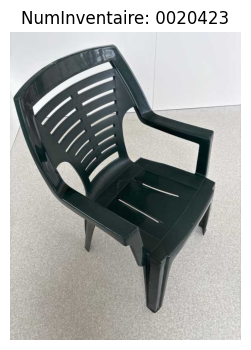

→ Fiche textuelle prédite :
 CHAISES PLIABLES (I) POLYETHYLENE BLANCHE JM BRUNEAU
→ Fiche textuelle correcte :
 Portable compacq - selon devis  ARES ODA.IFER/005/15 du 30/05/2000 ARES
--------------------------------------------------------------------------------


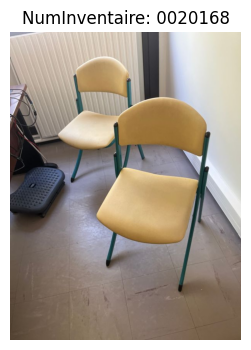

→ Fiche textuelle prédite :
 LOT DE 6 CHAISES 4 PIEDS FACTORY  REF UGAP 2324384 UGAP
→ Fiche textuelle correcte :
 CHAISES FIXES EMPILABLES SERIE 250 PIETEMENT JADE EXPANSE MAIS SELECTION 01 SOUVIGNET
--------------------------------------------------------------------------------


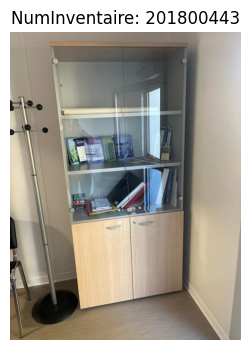

→ Fiche textuelle prédite :
 1 ARMOIRE A PHARMACIE MURALE REFERENCE 30857 - (CMP de Dourdan ETABLISSEMENTS VILLARD SA
→ Fiche textuelle correcte :
 BUREAU DROIT 140X80+ MONTAGE  JM BRUNEAU
--------------------------------------------------------------------------------

✅ Exemples correctement prédits :



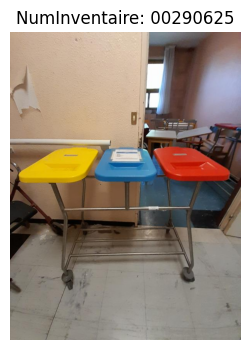

→ Fiche textuelle prédite :
 CHARIOT SUPPORT 3 SACS AVEC COUVERCLES JAUNE-BLEU-ROUGE PS3 ISEO REF 6030 FRANCE HOPITAL
→ Fiche textuelle correcte :
 CHARIOT SUPPORT 3 SACS AVEC COUVERCLES JAUNE-BLEU-ROUGE PS3 ISEO REF 6030 FRANCE HOPITAL
--------------------------------------------------------------------------------


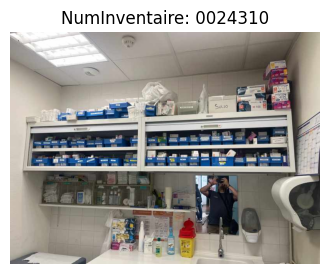

→ Fiche textuelle prédite :
 1 ARMOIRE A PHARMACIE MURALE REFERENCE 30857 - (CMP de Dourdan ETABLISSEMENTS VILLARD SA
→ Fiche textuelle correcte :
 1 ARMOIRE A PHARMACIE MURALE REFERENCE 30857 - (CMP de Dourdan ETABLISSEMENTS VILLARD SA
--------------------------------------------------------------------------------


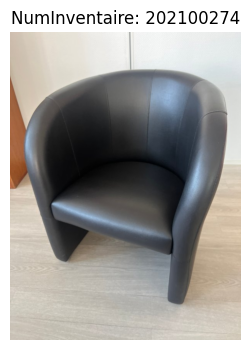

→ Fiche textuelle prédite :
 FAUTEUIL CLUB DREAM - NOIR REF. 1468958 UGAP
→ Fiche textuelle correcte :
 FAUTEUIL CLUB DREAM - NOIR REF. 1468958 UGAP
--------------------------------------------------------------------------------


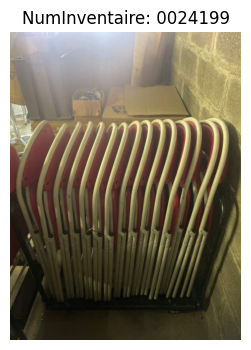

→ Fiche textuelle prédite :
 200 CHAISES PLIANTES URBA - revêtement expansé sur jersey selection 01 SIGNATURE SARL
→ Fiche textuelle correcte :
 200 CHAISES PLIANTES URBA - revêtement expansé sur jersey selection 01 SIGNATURE SARL
--------------------------------------------------------------------------------


In [ ]:
import random
import matplotlib.pyplot as plt
import torch

# --- 1️⃣ 5 exemples aléatoires ---
print("🎲 Exemples aléatoires :\n")

sample_indices = random.sample(range(len(df_test_sample)), 5)

for i in sample_indices:
    sims = similarity_matrix[i]
    top1_idx = torch.argmax(sims).item()
    predicted_text = df_test_sample["fiche_textuelle"].iloc[top1_idx]
    true_text = df_test_sample["fiche_textuelle"].iloc[i]

    plt.figure(figsize=(4, 4))
    plt.imshow(df_test_sample["image_obj"].iloc[i])
    plt.axis("off")
    plt.title(f"NumInventaire: {df_test_sample['NumInventaire'].iloc[i]}")
    plt.show()

    print("→ Fiche textuelle prédite :\n", predicted_text)
    print("→ Fiche textuelle correcte :\n", true_text)
    print("-" * 80)


# --- 2️⃣ 5 exemples correctement prédits ---
print("\n✅ Exemples correctement prédits :\n")

good_indices = []
for i in range(len(df_test_sample)):
    sims = similarity_matrix[i]
    top1_idx = torch.argmax(sims).item()
    if top1_idx == i:  # prédiction correcte
        good_indices.append(i)

if len(good_indices) == 0:
    print("Aucun bon résultat trouvé 😅")
else:
    selected = random.sample(good_indices, min(5, len(good_indices)))

    for i in selected:
        sims = similarity_matrix[i]
        top1_idx = torch.argmax(sims).item()
        predicted_text = df_test_sample["fiche_textuelle"].iloc[top1_idx]
        true_text = df_test_sample["fiche_textuelle"].iloc[i]

        plt.figure(figsize=(4, 4))
        plt.imshow(df_test_sample["image_obj"].iloc[i])
        plt.axis("off")
        plt.title(f"NumInventaire: {df_test_sample['NumInventaire'].iloc[i]}")
        plt.show()

        print("→ Fiche textuelle prédite :\n", predicted_text)
        print("→ Fiche textuelle correcte :\n", true_text)
        print("-" * 80)
